# Unraveling LAM and LLI

Andrew Weng

Dec 9, 2021

Use basic analytical equations for LAM and LLI to explore the relationship between graphical voltage features and the underlying math.

The idea is: usually people start from the graphs and try to recover LAM and LLI. In this work, we start from the fundamental math behind LAM and LLI and construct the graphs using a toy model. We show how the graphical features map to the LAM and LLI. We will show that LLI cannot be directly attributed to SEI reaction mechanisms in the presence of LAM.


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Configure Pandas and Matplotlib Settings

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

# Configure plot settings
plt.rc('font', **{'family'     : 'sans-serif',
                  'sans-serif' : ['Arial'],
                  'size': 14
                  })
plt.rc('figure', **{'autolayout' : True,
                    'figsize'    : (7, 5),
                    'facecolor'  : 'white',
                    'dpi'        : 150
                    })
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')
plt.rc('axes',  labelsize='medium', grid=False)
plt.rc('axes',  titlesize='medium')
plt.rc('legend', fontsize='medium')


# Define Functions

In [3]:
def Up(sto):
    """
    Nickel Managanese Cobalt Oxide (NMC) Open Circuit Potential (OCP) as a
    function of the stochiometry. The fit is taken from Peyman MPM.
    References
    ----------
    Peyman MPM manuscript (to be submitted)
    Parameters
    ----------
    sto : :class:`pybamm.Symbol`
       Stochiometry of material (li-fraction)
    """

    u_eq = (
        4.3452
        - 1.6518 * sto
        + 1.6225 * (sto ** 2)
        - 2.0843 * (sto ** 3)
        + 3.5146 * (sto ** 4)
        - 2.2166 * (sto ** 5)
        - 0.5623e-4 * np.exp(109.451 * sto - 100.006)
    )

    return u_eq

In [4]:
def Un(sto):
    """
    Graphite Open Circuit Potential (OCP) as a function of the
    stochiometry. The fit is taken from Peyman MPM [1].
    References
    ----------
    .. [1] Peyman Mohtat et al, MPM (to be submitted)
    """

    u_eq = (
        0.063
        + 0.8 * np.exp(-75 * (sto + 0.001))
        - 0.0120 * np.tanh((sto - 0.127) / 0.016)
        - 0.0118 * np.tanh((sto - 0.155) / 0.016)
        - 0.0035 * np.tanh((sto - 0.220) / 0.020)
        - 0.0095 * np.tanh((sto - 0.190) / 0.013)
        - 0.0145 * np.tanh((sto - 0.490) / 0.020)
        - 0.0800 * np.tanh((sto - 1.030) / 0.055)
    )

    return u_eq

In [6]:
Cn = 4
Cp = 5
x100 = 0.9
y100 = 0.2

In [23]:
Q = np.arange(0, 3.8, 0.01)

Up_curr = Up(y100 + Q/Cp) 
Un_curr = Un(x100 - Q/Cn)

OCV = Up_curr - Un_curr

(0.0, 4.3)

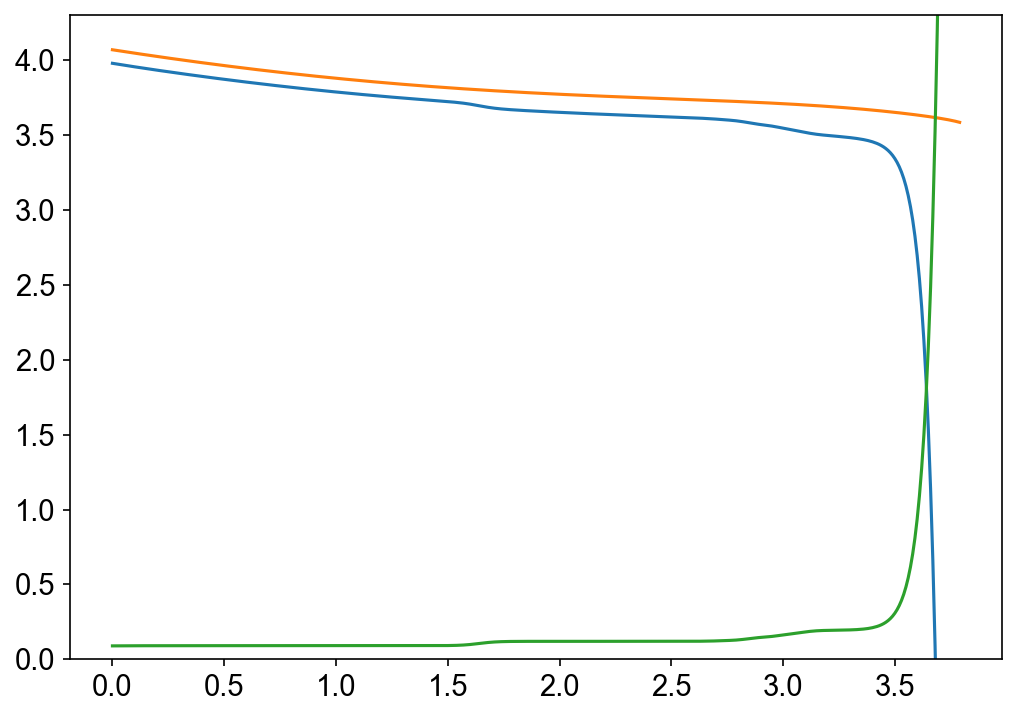

In [25]:
plt.figure()
plt.plot(Q, OCV, Q, Up_curr, Q, Un_curr)
plt.ylim((0, 4.3))

# Check the electrode equilibrium curves

Text(0, 0.5, 'U (V vs Li/Li$^+$)')

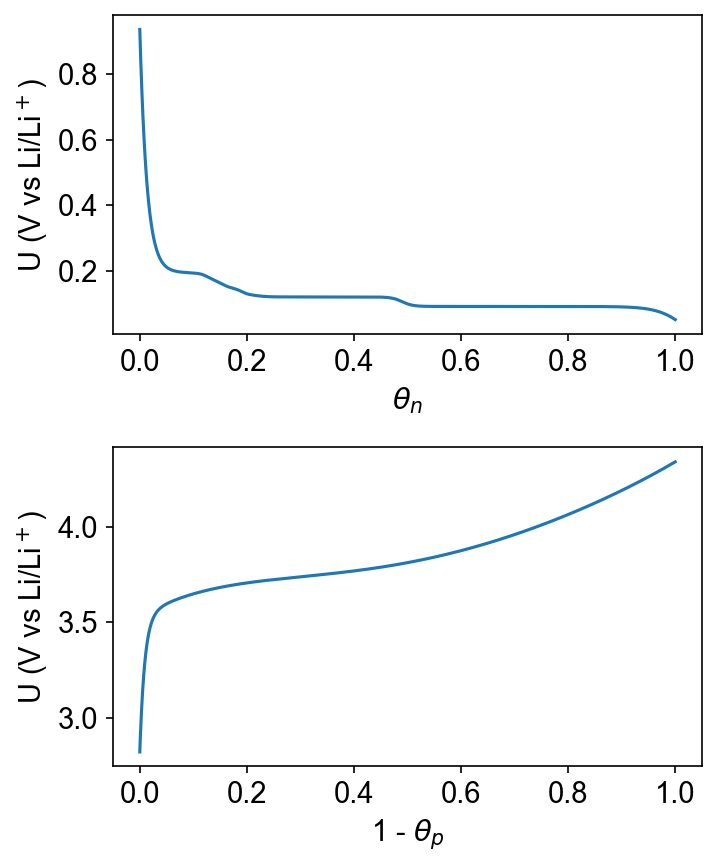

In [5]:
plt.figure(figsize=(5, 6))

theta_n = np.linspace(0, 1, 1000)
theta_p = np.linspace(0, 1, 1000)

plt.subplot(2, 1, 1)
plt.plot(theta_n, Un(theta_n))
plt.xlabel(r'$\theta_n$')
plt.ylabel('U (V vs Li/Li$^+$)')
plt.subplot(2, 1, 2)
plt.plot(1 - theta_p, Up(theta_p))
plt.xlabel(r'1 - $\theta_p$')
plt.ylabel('U (V vs Li/Li$^+$)')

In [6]:
Cn = 5.97 # Ah
Cp = 5.97 # Ah

nLi = 0.19 # moles

F = 96500 # C mol-1

nLi_SEI = 0.19 # moles

theta_n_100 = 0.3
theta_p_100 = 0.9

n_li = 3600/F * (theta_n_100 * Cn + theta_p_100 * Cp)

$C = C_n (\theta_n^{100} - \theta_n^0) = C_p (\theta_p^{0} - \theta_p^{100})$

# Pure Graphical Analysis

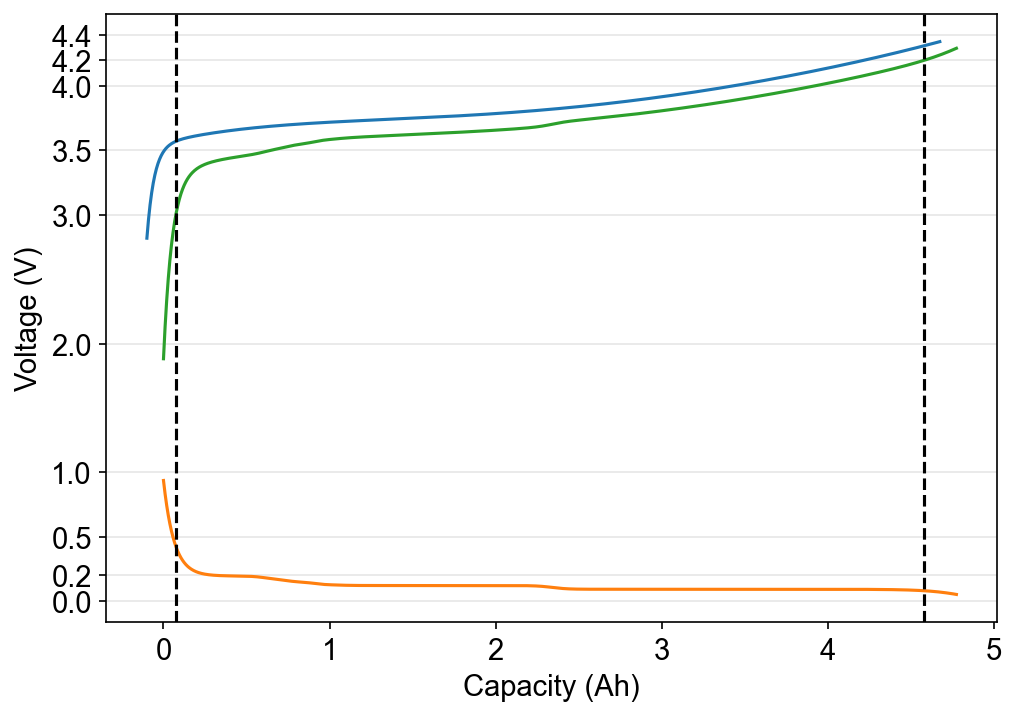

In [19]:
# Define degradation parameters

delta_nlli = 0.1 # in Ah
lam_pe = 0.2     # in %/100
lam_ne = 0.2     # in %/100

# Initial positive and negative stoic curves
Cp_theta_vec = np.linspace(0, 1, 1000) 
Up_vec = Up(1 - Cp_theta_vec)                # Cathode stoic is flipped!

Cn_theta_vec = np.linspace(0, 1, 1000)
Un_vec = Un(Cn_theta_vec)

# Conver the stoic curves to capacity curves
Cp_vec = Cp_theta_vec * Cp * (1 - lam_pe)
Cn_vec = Cn_theta_vec * Cn * (1 - lam_ne)

# Expanded capacity vector
C = np.linspace(np.min([np.min(Cp_vec), np.min(Cn_vec)]), 
                np.max([np.max(Cp_vec), np.max(Cn_vec)]), 1000)

# Expanded voltage vectors
Up_vec_interp = np.interp(C, Cp_vec, Up_vec)
Un_vec_interp = np.interp(C, Cn_vec, Un_vec)

U = Up_vec_interp - Un_vec_interp

# Extract theta values
VMIN = 3.0
VMAX = 4.2

q0_ref = np.interp(VMIN, U, C)
q100_ref = np.interp(VMAX, U, C)

theta_p_0 = 1 - (np.interp(q0_ref, Cp_vec, Up_vec)) / Cp
theta_p_100 = 1 - (np.interp(q100_ref, Cp_vec, Up_vec)) / Cp

theta_n_0 = q0_ref / Cn
theta_n_100 = q100_ref / Cn

delta_nlli_calc = theta_p_100 * Cp + theta_n_100 * Cn

plt.figure()

plt.plot(Cp_vec - delta_nlli, Up_vec)
plt.plot(Cn_vec, Un_vec)
plt.plot(C, U)

# Voltage range
plt.axvline(q0_ref, color='k', linestyle='--')
plt.axvline(q100_ref, color='k', linestyle='--')

plt.xlabel('Capacity (Ah)')
plt.ylabel('Voltage (V)')
plt.yticks([0, 0.2, 0.5, 1.0, 2.0, 3.0, 3.5, 4.0, 4.2, 4.4])
plt.grid(axis='y', c=(0.9, 0.9, 0.9))

In [8]:
delta_nlli_calc

1.7699999999999998

In [9]:
Cp

5.97

In [17]:
q100_ref

4.581129536053794

In [10]:
Cn

5.97

In [21]:
theta_p_100

0.2830196769704235

In [22]:
theta_n_100

0.7673583812485417

In [23]:
theta_n_0

0.012465670636154136